# AlloBench Dataset Creation Pipeline

TODO: Fix Active Site annotation with respect to PDB and not Uniprot

Add Protein Name Organism from PDB and UniProt

Check PDB files unavailable as .pdb, download mmCIF, convert to PDB if the residue model is missing, and save the structure.

## Process the AlloSteric Database (ASD) Data

Download the ASD_Release_202306_XF.tar.gz from https://mdl.shsmu.edu.cn/ASD/module/download/download.jsp?tabIndex=1 and place it in the directory of this notebook.

In [1]:
# Input file
asd_xml_archive = 'ASD_Release_202306_XF.tar.gz'  # Change the archive name and path as required
asd_data_file = 'ASD_Release_202309_AS.txt'

# Output filenames
asd_output_filename = "ASD_Updated.csv"  # ASD data with updated UniProt and PDB IDs
asd_enriched_filename = 'ASD_Enriched.csv'   # ASD data with additional information from UniProt and PDB
output_filename = 'AlloBench.csv'        # Final output file


### 1. Parse the data in ASD XML Files

In [2]:
import glob
import os

import pandas as pd
from tqdm.notebook import tqdm
import xmltodict
import tarfile


def parse_allosteric_site(alloteric_site):
    """Convert the list of residues in ASD from "Chain A:HIS25,TYR258; Chain B:VAL325" to ['A-HIS-25', 'A-TYR-258', 'B-VAL-325']"""
    residues = []
    for chain_string in alloteric_site.split('; '):
        chain_name, residue_string = chain_string.split(':')
        chain_id = chain_name[-1]
        for residue in residue_string.split(','):
            res_name, res_id = residue[:3], residue[3:]
            residues.append(f'{chain_id}-{res_name}-{res_id}')
    return residues


def parse_asd_xml(xml_string: str) -> tuple:
    """parse a directory containing XML files from the ASD database to create a pandas DataFrame"""
    xml_string = xml_string.replace('&#x2;', '')  # Remove invalid XML character
    protein = xmltodict.parse(xml_string)

    target_gene = ''
    target_id = protein['Organism_Record']['Organism_ID']

    if 'Gene' in protein['Organism_Record'] and 'Gene_Name' in protein['Organism_Record']['Gene']:
        target_gene = protein['Organism_Record']['Gene']['Gene_Name']

    organism = protein['Organism_Record']['Organism']

    # Check if the list of allosteric sites in present in the XML file
    if 'Allosteric_Site_List' in protein['Organism_Record']:
        allosteric_sites = protein['Organism_Record']['Allosteric_Site_List']['Allosteric_Site']

        # Check if more than one allosteric site is present
        if isinstance(allosteric_sites, list):
            allosteric_sites = allosteric_sites
        else:
            allosteric_sites = [allosteric_sites]
    else:
        allosteric_sites = []

    output = []
    for site in allosteric_sites:
        if site:
            pdb_uniprot = site['PDB_UniProt_ID'].upper() if 'PDB_UniProt_ID' in site else ''
            allosteric_pdb = site['Allosteric_PDB'].upper()
            modulator_serial = site['Modulator_ASD_ID']
            modulator_alias = site['Modulator_Alias']
            modulator_chain = site['Modulator_Chain']
            modulator_class = site['Modulator_Class'] if 'Modulator_Class' in site else ''
            modulator_feature = site['Modulator_Feature'] if 'Modulator_Feature' in site else ''
            modulator_name = site['Modulator_Name'] if 'Modulator_Name' in site else ''
            modulator_resi = site['Modulator_Residue'] if 'Modulator_Residue' in site else ''
            function = site['Function'] if 'Function' in site else ''
            position = site['Position'] if 'Position' in site else ''
            pubmed_id = site['PubMed_ID'] if 'PubMed_ID' in site else ''
            ref_title = site['PubMed_Title'] if 'PubMed_Title' in site else ''
            site_overlap = site['Site_Overlap'] if 'Site_Overlap' in site else ''
            allosteric_site_residue = parse_allosteric_site(site['Allosteric_Site_Residue']) if 'Allosteric_Site_Residue' in site else []

            output.append([
                target_id, target_gene, organism, pdb_uniprot, allosteric_pdb,
                modulator_serial, modulator_alias, modulator_chain,
                modulator_class, modulator_feature, modulator_name,
                modulator_resi, function, position, pubmed_id, ref_title,
                site_overlap, allosteric_site_residue])
    return output


def asd_to_df(asd_xml_archive):
    asd_data = []
    with tarfile.open(asd_xml_archive, 'r:gz') as tar_data:
        for xml_file in tar_data:
            xml_data = tar_data.extractfile(xml_file)
            if xml_data is not None:
                xml_string = xml_data.read().decode("utf-8")
                asd_data.extend(parse_asd_xml(xml_string))

    return pd.DataFrame(asd_data, columns=[
        'target_id', 'target_gene', 'organism', 'pdb_uniprot', 'allosteric_pdb',
        'modulator_serial', 'modulator_alias', 'modulator_chain', 'modulator_class',
        'modulator_feature', 'modulator_name', 'modulator_resi', 'function',
        'position', 'pubmed_id', 'ref_title', 'site_overlap',
        'allosteric_site_residue'])

In [3]:
df_asd = asd_to_df(asd_xml_archive)
# df_asd = pd.read_table(asd_data_file)

df_asd.rename(columns={
    'target_id': 'Protein ASD ID',
    'target_gene': 'Gene',
    'organism': 'Organism',
    'pdb_uniprot': 'UniProt ID',
    'allosteric_pdb': 'PDB ID',
    'modulator_serial': 'Modulator ASD ID',
    'modulator_alias': 'Modulator Alias',
    'modulator_chain': 'Modulator Chain',
    'modulator_class': 'Modulator Class',
    'modulator_feature': 'Allosteric Activity',
    'modulator_name': 'Modulator Name',
    'modulator_resi': 'Modulator Residue ID',
    'function': 'ASD Function',
    'position': 'Position',
    'pubmed_id': 'PubMed',
    'ref_title': 'Reference Title',
    'site_overlap': 'Site Overlap',
    'allosteric_site_residue': 'ASD Allosteric Site Residues'
}, inplace=True)

In [4]:
df_asd['PDB ID'] = df_asd['PDB ID'].str.upper()
df_asd['UniProt ID'] = df_asd['UniProt ID'].str.upper()

print('Number of Rows:             ', df_asd.shape[0])
print('Number of Unique PDB IDs:   ', df_asd['PDB ID'].nunique())
print('Number of Unique UniProt AC:', df_asd['UniProt ID'].nunique())

Number of Rows:              3172
Number of Unique PDB IDs:    2993
Number of Unique UniProt AC: 701


In [71]:
df_asd[df_asd.duplicated('PDB ID', keep=False)]

,Protein ASD ID,Gene,Organism,UniProt ID,PDB ID,Modulator ASD ID,Modulator Alias,Modulator Chain,Modulator Class,Allosteric Activity,Modulator Name,Modulator Residue ID,ASD Function,Position,PubMed,Reference Title,Site Overlap,ASD Allosteric Site Residues
56,ASD00250000_6,,Potato,P23509,1YP4,ASD02880002,SO4,A,Ion,Activator,sulfate,1007,Inner Protein Regulator,Inner Protein,15692569,Crystal structure of potato tuber ADP-glucose ...,No,"[A-LYS-69, A-GLU-133, A-HIS-134, A-THR-135]"
57,ASD00250000_6,,Potato,P23509,1YP3,ASD02880002,SO4,A,Ion,Activator,sulfate,1007,Inner Protein Regulator,Inner Protein,15692569,Crystal structure of potato tuber ADP-glucose ...,No,"[A-LYS-69, A-GLU-133, A-HIS-134, A-THR-135, D-..."
58,ASD00250000_6,,Potato,P23509,1YP2,ASD02880002,SO4,A,Ion,Activator,sulfate,2007,Inner Protein Regulator,Inner Protein,15692569,Crystal structure of potato tuber ADP-glucose ...,No,"[A-LYS-69, A-GLU-133, A-HIS-134, A-THR-135, D-..."
59,ASD00250000_6,,Potato,P23509,1YP2,ASD02880002;ASD02880002,SO4;SO4,A;A,Ion,Activator,sulfate;sulfate,2000;2008,Inner Protein Regulator,Protein-Protein Interaction,15692569,Crystal structure of potato tuber ADP-glucose ...,No,"[A-ARG-41, A-PRO-47, A-ARG-53, A-HIS-84, A-GLN..."
60,ASD00250000_6,,Potato,P23509,1YP4,ASD02880002;ASD02880002,SO4;SO4,A;A,Ion,Activator,sulfate;sulfate,1000;1008,Inner Protein Regulator,Protein-Protein Interaction,15692569,Crystal structure of potato tuber ADP-glucose ...,No,"[A-ARG-41, A-PRO-47, A-ARG-53, A-SER-80, A-ARG..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860,ASD16670000_1,IDH3G,Human,P51553,6L57,None,CIT,B,Lig,Regulator,CITRIC ACID,401,None,None,,,None,[]
2861,ASD16670000_1,IDH3G,Human,P51553,6L57,None,ATP,B,Lig,Activator,ADENOSINE-5'-TRIPHOSPHATE,403,Allosteric function,Allosteric position,,,No,[]
2889,ASD16880000_1,,Cyanophage S-TIM5,H6WFU3,4P9D,ASD02040015,TTP,A,Lig,Inhibitor,THYMIDINE-5'-TRIPHOSPHATE,203,Allosteric function,Allosteric position,25404739,The First Crystal Structure of a dTTP-bound De...,No,[B-LYS-2]
2902,ASD16940000_1,,Plasmodium falciparum (isolate 3D7),Q7KQK0,5T3N,ASD16940001,75G,A,Lig,Inhibitor,"(2S,4aR,6R,7R,7aS)-6-(6-amino-2-chloro-9H-puri...",503,Inner Protein regulator,Inner Protein,27738107,Disrupting the Allosteric Interaction between ...,Yes,"[A-GLU-377, A-ILE-366, A-ILE-340, A-ALA-359, A..."


### 2. Fix Obsolete PDB Entries

The structures of the biomolecules will be downloaded from the PDB; thus, having the correct PDB IDs is essential. Some PDB IDs in ASD are obsolete. The list of obsolete PDB IDs is downloaded from the Protein Data Bank. The obsolete PDB IDs are replaced by the superseded PDB IDs, and structures without any superseded PDB IDs are removed.

In [5]:
import requests
import json
import gzip
import pandas as pd

response = requests.get('https://files.wwpdb.org/pub/pdb/holdings/all_removed_entries.json.gz')

obsolete_pdb = {}
for pdb_id, value in json.loads(gzip.decompress(response.content)).items():
    if 'superseded_by' in value:
        # Select the last element in the list of superseded PDB IDs
        obsolete_pdb[pdb_id] = value['superseded_by'] # [-1] 
    else:
        obsolete_pdb[pdb_id] = []


df_obsolete_pdb = pd.DataFrame.from_dict(obsolete_pdb, orient='index')
df_obsolete_pdb.index.name = 'Obsolete PDB ID'

# Obsolete PDB IDs in ASD
df_obsolete_pdb_asd = df_obsolete_pdb[df_obsolete_pdb.index.isin(df_asd['PDB ID'])]

# Replace the obsolete PDB IDs
df_asd['PDB ID'] = df_asd['PDB ID'].replace(df_obsolete_pdb_asd.to_dict()[0])

# Check if any of the obsolete PDB IDs had more than one updated PDB IDs
df_obsolete_pdb_asd

,0,1,2
Obsolete PDB ID,,,
1HWZ,6DHD,None,None
3MVQ,6DHL,None,None
3MW9,6DHM,None,None
3QMU,6DHQ,None,None
4GAR,4V9C,None,None
4GAU,4V9C,None,None
4LEG,5J94,None,None


While most obsolete PDB IDs are superseded by only one PDB ID, there exists obsolete PDB IDs superseded by multiple PDB IDs. However, the ASD does not contain such structures.

In [6]:
print('Number of Rows:             ', df_asd.shape[0])
print('Number of Unique PDB IDs:   ', df_asd['PDB ID'].nunique())
print('Number of Unique UniProt AC:', df_asd['UniProt ID'].nunique())

Number of Rows:              3172
Number of Unique PDB IDs:    2991
Number of Unique UniProt AC: 701


### 3. Update UniProt IDs

The active site information will be obtained from the UniProt database hence it is critical to have the correct UniProt ID for the ASD protein structures.

In [7]:
def uniprot_from_pdb(pdb_ids):
    """ Get the UniProt IDs for the chains in the structures with the PDB IDs """
    pdb_ids_string = '", "'.join(pdb_ids)

    body = 'query {entries(entry_ids: ["' + pdb_ids_string + '"])' + """
      {
        rcsb_id
        polymer_entities {
          uniprots {
            rcsb_id
          }
        }
      }
    }
    """
    response = requests.post(url='https://data.rcsb.org/graphql', json={"query": body})
    response_data = response.json()

    id_mapping = []
    for record in response_data['data']['entries']:
        rcsb_id = record['rcsb_id']
        uniprot_ids = set()
        for entity in record['polymer_entities']:
            if entity['uniprots']:
                uniprot_ids.add(entity['uniprots'][0]['rcsb_id'])
        id_mapping.append([rcsb_id, uniprot_ids])
        
    return pd.DataFrame(id_mapping, columns=['PDB ID', 'PDB UniProt ID'])

In [8]:
# Create a pandas DataFrame with only PDB ID and UniProt ID
df_asd_subset = df_asd[['PDB ID', 'UniProt ID']].drop_duplicates().copy()

# Get the UniProt IDs of the chains in the proteins from PDB website
df_pdb = uniprot_from_pdb(df_asd_subset['PDB ID'])

df_pdb

,PDB ID,PDB UniProt ID
0,1KFL,{P0AB91}
1,6AGM,{P00888}
2,3PG9,{Q9WYH8}
3,1OF6,{P32449}
4,1OFR,{P32449}
...,...,...
2992,6FMU,{}
2993,6FMZ,{}
2994,6FTC,{}
2995,6I2P,"{P9WI81, P9WJA9}"


In [9]:
# Count the number of UniProt IDs obtained from PDB website for each PDB ID
df_pdb['_num_pdb_uniprot'] = df_pdb['PDB UniProt ID'].apply(len)
df_merged = df_asd_subset.merge(df_pdb.dropna(subset='PDB UniProt ID'), how='left', on='PDB ID')

# Check if the UniProt ID in ASD is present in the UniProt IDs obtained from PDB website
df_merged['_present'] = df_merged.apply(lambda x: x['UniProt ID'] in x['PDB UniProt ID'], axis=1)

df_present = df_merged.loc[df_merged['_present'], ['PDB ID', 'UniProt ID']]
df_present['PDB UniProt ID'] = df_present['UniProt ID']

# UniProt IDs absent in the ASD but has only one UniProt ID downloaded from PDB
df_absent_single = df_merged[~df_merged['_present'] & (df_merged['_num_pdb_uniprot'] == 1)].copy()

# Place the only one UniProt ID from the set in Uniprot ID column to UniProt ID column
if not df_absent_single.empty:
    df_absent_single['PDB UniProt ID'] = df_absent_single.apply(lambda x: next(iter(x['PDB UniProt ID'])), axis=1)
df_absent_single = df_absent_single[['PDB ID', 'UniProt ID', 'PDB UniProt ID']]

# Combine the UniProt ID that are present and those returned only one UniProt ID
df_asd_pdb_uniprot = pd.concat([df_present, df_absent_single])

df_absent_multiple = df_merged[~df_merged['_present'] & (df_merged['_num_pdb_uniprot'] != 1)]
print("PDB IDs Absent from ASD with Zero or Multiple UniProt ID fetched from the PDB")
df_absent_multiple[['PDB ID', 'UniProt ID', 'PDB UniProt ID']].sort_values('PDB ID').reset_index(drop=True)

PDB IDs Absent from ASD with Zero or Multiple UniProt ID fetched from the PDB


,PDB ID,UniProt ID,PDB UniProt ID
0,1CKK,P62158,"{P0DP33, P97756}"
1,1IQ5,P62158,"{Q3Y416, P0DP33}"
2,1NWD,P62158,"{Q07346, P0DP33}"
3,3J41,P62158,"{P0DP23, Q6J8I9}"
4,3OBK,S8F7E9,{}
5,3OWI,,{}
6,3OWW,,{}
7,3OWZ,,{}
8,3OXE,,{}
9,3OXJ,,{}


Note that the PDB IDs: 3OWZ, 3OXM, 3OWI, 3Q3Z, 3OXJ, 3OWW, 3OXE are structures of glycine riboswitch, an RNA element and do not have an associated UniProt IDs.

In [10]:
# Reinsert PDB ID and UniProt AC combination from the manual curation of the table above
df_manual_curation = pd.DataFrame(data=[
        ['1CKK', 'P62158', 'P0DP33'],
        ['1IQ5', 'P62158', 'P0DP33'],
        ['1NWD', 'P62158', 'P0DP33'],
        ['3J41', 'P62158', 'P0DP23'],
        ['3OBK', 'S8F7E9', 'S8F7E9'],
        ['3RHW', 'O17793', 'G5EBR3'],
        ['3RI5', 'O17793', 'G5EBR3'],
        ['3RIA', 'O17793', 'G5EBR3'],
        ['3RIF', 'O17793', 'G5EBR3'],
        ['4A2U', 'I6Y496', 'P9WP65'],
        ['4P86', 'P39765', 'P39765'],
        ['6KDY', 'Q43837', 'O43837'],
        ['6UI4', 'A0A098D3M4', 'I1RCT2'],
        ['7LD3', 'P30542', 'P30542'],
        ['7O83', 'P01116', 'P01116']
    ],
    columns=['PDB ID', 'UniProt ID', 'PDB UniProt ID'])

df_asd_pdb_uniprot = pd.concat([df_asd_pdb_uniprot, df_manual_curation])

In [11]:
df_asd_updated =  df_asd.merge(df_asd_pdb_uniprot.drop_duplicates(), how='left')

# Replace the Old UniProt IDs with the New UniProt IDs obtained from the PDB
df_asd_updated['UniProt ID'] = df_asd_updated['PDB UniProt ID']
df_asd_updated.drop(columns='PDB UniProt ID', inplace=True)
df_asd_updated.dropna(subset=['UniProt ID', 'PDB ID'], inplace=True)

print('Number of Rows:             ', df_asd_updated.shape[0])
print('Number of Unique PDB IDs:   ', df_asd_updated['PDB ID'].nunique())
print('Number of Unique UniProt AC:', df_asd_updated['UniProt ID'].nunique())

df_asd_updated.to_csv(asd_output_filename, index=False)

Number of Rows:              3148
Number of Unique PDB IDs:    2968
Number of Unique UniProt AC: 690


## Merge with Additional Information from the PDB

Add a mapping from PDB Chains to UniProt IDs and Squences. Also add the oligomeric state of the target protein, its stoichiometry, experimental method to obtain the structure and resolution of the structure.

In [12]:
# Obtain the data from PDB using GraphQL API.
def get_pdb_data(pdb_ids):
    query = """query structure($pdb_ids: [String!]!) {
  entries(entry_ids: $pdb_ids) {
    rcsb_id
    rcsb_entry_info {
          experimental_method
          resolution_combined
        }
    assemblies {
      rcsb_id
      polymer_entity_instances {
        rcsb_id
        polymer_entity {
          entity_poly {
            pdbx_seq_one_letter_code_can
          }
          uniprots {
            rcsb_id
          }
        }
      }
      rcsb_struct_symmetry {
        kind
        oligomeric_state
        stoichiometry
      }
    }
  }
}"""
    response = requests.post(url='https://data.rcsb.org/graphql', json={"query": query, "variables": {"pdb_ids": list(pdb_ids)}})
    response_data = response.json()
    
    pdb_data = []
    for entry in response_data['data']['entries']:
        pdb_id = entry['rcsb_id']
        experimental_method = entry['rcsb_entry_info']['experimental_method']

        resolution = entry['rcsb_entry_info']['resolution_combined']
        if resolution and len(resolution) == 1:
            resolution = resolution[0]

        first_assembly = entry['assemblies'][0]
        # assembly_id = first_assembly['rcsb_id'].split('-')[1]

        chain_uniprot_mapping = []
        for polymer_entity in first_assembly['polymer_entity_instances']:
            chain = polymer_entity['rcsb_id'].split('.')[1]
            sequence = polymer_entity['polymer_entity']['entity_poly']['pdbx_seq_one_letter_code_can']
            polymer_entity_uniprot = polymer_entity['polymer_entity']['uniprots']
            uniprot_ids = []
            if polymer_entity_uniprot:
                for uniprot_id in polymer_entity_uniprot:
                    uniprot_ids.append(uniprot_id['rcsb_id'])
            chain_uniprot_mapping.append([chain, uniprot_ids, sequence])

        if first_assembly['rcsb_struct_symmetry'] is not None:
            for symmetry in first_assembly['rcsb_struct_symmetry']:
                if symmetry['kind'] == 'Global Symmetry':
                    oligomeric_state = symmetry['oligomeric_state']
                    stoichiometry = symmetry['stoichiometry']
        else:
            oligomeric_state = None
            stoichiometry = None
        pdb_data.append([pdb_id, chain_uniprot_mapping, oligomeric_state, stoichiometry, experimental_method, resolution])

    return pd.DataFrame(pdb_data, columns=['PDB ID', 'Map PDB Chain to UniProt', 'Oligomeric State', 'Stoichiometry', 'Experimental Method', 'Resolution'])

In [13]:
df_pdb = get_pdb_data(df_asd_updated['PDB ID'].unique())
df_asd_pdb_merged = df_asd_updated.merge(df_pdb)

print('Number of Rows:             ', df_asd_pdb_merged.shape[0])
print('Number of Unique PDB IDs:   ', df_asd_pdb_merged['PDB ID'].nunique())
print('Number of Unique UniProt AC:', df_asd_pdb_merged['UniProt ID'].nunique())

Number of Rows:              3148
Number of Unique PDB IDs:    2968
Number of Unique UniProt AC: 690


## Get protein name and reivew status from UniProt

In [14]:
import SPARQLWrapper
import itertools
import pandas as pd

def uniprot_protein_name(uniprot_ids):
    # Set the SPARQL endpoint (UniProt)
    sparql = SPARQLWrapper.SPARQLWrapper("https://sparql.uniprot.org/sparql")

    output = []
    for uniprot_subset in itertools.batched(uniprot_ids, 200):
        uniprot_string = ' '.join([f'uniprotkb:{id}' for id in uniprot_subset])
                 
        # Define the query
        query_string = f"""
PREFIX up: <http://purl.uniprot.org/core/>
PREFIX uniprotkb: <http://purl.uniprot.org/uniprot/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
SELECT DISTINCT ?uniprot_id ?reviewed ?name
WHERE
{{
  VALUES ?protein {{ {uniprot_string} }}
  BIND(substr(str(?protein), strlen(str(uniprotkb:))+1) AS ?uniprot_id)
  ?protein up:reviewed ?reviewed .
  OPTIONAL {{
    ?protein up:recommendedName ?recommended .
    ?recommended up:fullName ?name .
  }}
}}
"""
        sparql.setQuery(query_string)
    
        # Set the output format as JSON
        sparql.setReturnFormat(SPARQLWrapper.JSON)
        
        # Run the SPARQL query and convert to the defined format
        data = sparql.query().convert()

        # Store the query result
        for result in data["results"]["bindings"]:
            output.append({key: value['value'] for key, value in result.items()})
    return pd.DataFrame(output, columns=['uniprot_id', 'reviewed', 'name']).rename(
        columns={'uniprot_id': 'UniProt ID', 'reviewed': 'Reviewed', 'name': 'Protein Name'})

In [15]:
df_uniprot = uniprot_protein_name(list(df_asd_pdb_merged['UniProt ID'].unique()))
df_asd_enriched = df_asd_pdb_merged.merge(df_uniprot)

print('Number of Rows:             ', df_asd_enriched.shape[0])
print('Number of Unique PDB IDs:   ', df_asd_enriched['PDB ID'].nunique())
print('Number of Unique UniProt AC:', df_asd_enriched['UniProt ID'].nunique())

df_asd_updated.to_csv(asd_enriched_filename, index=False)

Number of Rows:              3148
Number of Unique PDB IDs:    2968
Number of Unique UniProt AC: 690


## Get Catalytic Site Atlas Data

1. Get the manually curated catalytic residues from the Mechanism and Catalytic Site Atlas (M-CSA)
2. Parse the JSON file and create a pandas dataframe

In [16]:
response = requests.get('https://www.ebi.ac.uk/thornton-srv/m-csa/api/residues/?format=json')
mcsa_data = response.json()

output = []
for i, entry in enumerate(mcsa_data):
    if entry['residue_chains']:
        chain_name          = entry['residue_chains'][0]['chain_name']
        pdb_id              = entry['residue_chains'][0]['pdb_id'].upper()
        assembly_chain_name = entry['residue_chains'][0]['assembly_chain_name']
        assembly            = entry['residue_chains'][0]['assembly']
        code                = entry['residue_chains'][0]['code']
        resid               = entry['residue_chains'][0]['resid']
    else:
        chain_name          = ''
        pdb_id              = ''
        assembly_chain_name = ''
        assembly            = ''
        code                = ''
        resid               = float('nan')
    uniprot_id          = entry['residue_sequences'][0]['uniprot_id']
    res_seq_code        = entry['residue_sequences'][0]['code']
    res_seq_resid       = entry['residue_sequences'][0]['resid']

    output.append([chain_name, pdb_id, assembly_chain_name, assembly,
                   code, resid, uniprot_id, res_seq_code, res_seq_resid])

df_csa = pd.DataFrame(output, columns=['chain_name', 'pdb_id',
                                       'assembly_chain_name', 'assembly',
                                       'code', 'resid', 'uniprot_id',
                                       'res_seq_code', 'res_seq_resid'])

In [17]:
# Make the UniProt and PDB IDs uppercase to facilitate merging on these later
df_csa['uniprot_id'] = df_csa['uniprot_id'].str.upper()
df_csa['pdb_id'] = df_csa['pdb_id'].str.upper()

# Replace the assembly_chain_name with chain_name if there are odd chain_name in assembly_chain_name column
df_csa.loc[df_csa['assembly_chain_name'].str.len() > 1, 'assembly_chain_name'] = df_csa['chain_name']
print('Number of UniProt IDs in M-CSA:', df_csa['uniprot_id'].nunique())

Number of UniProt IDs in M-CSA: 989


In [18]:
print('Number of Rows:             ', df_csa.shape[0])
print('Number of Unique PDB IDs:   ', df_csa['pdb_id'].nunique())
print('Number of Unique UniProt AC:', df_csa['uniprot_id'].nunique())

Number of Rows:              5248
Number of Unique PDB IDs:    1003
Number of Unique UniProt AC: 989


3. Download M-CSA PDB IDs

In [19]:
def uniprot_from_pdb_chains(pdb_chains):
    pdb_chains_string = '", "'.join(pdb_chains)
    
    body = 'query {polymer_entity_instances(instance_ids: ["' + pdb_chains_string + '"])' + """
      {
        rcsb_id
        polymer_entity {
          uniprots {
            rcsb_id
          }
        }
      }
    }
    """
    response = requests.post(url='https://data.rcsb.org/graphql', json={"query": body})
    response_data = response.json()

    id_mapping = []
    for record in response_data['data']['polymer_entity_instances']:
        rcsb_id, chain = record['rcsb_id'].split('.')
        if record['polymer_entity']['uniprots'] is not None:
            uniprot_id = record['polymer_entity']['uniprots'][0]['rcsb_id']
        else:
            uniprot_id = ''
        id_mapping.append([rcsb_id, chain, uniprot_id])
        
    return pd.DataFrame(id_mapping, columns=['pdb_id', 'chain', 'uniprot_id'])

### Update obsolete UniProt IDs

In [20]:
csa_pdb_chains = set(df_csa['pdb_id'] + '.' + df_csa['assembly_chain_name'])
df_csa_pdb = uniprot_from_pdb_chains(csa_pdb_chains)
df_csa_pdb = df_csa_pdb.rename(columns={'chain': 'assembly_chain_name', 'uniprot_id': 'pdb_uniprot_id'})
df_csa_merged = df_csa.merge(df_csa_pdb, how='left', on=['pdb_id', 'assembly_chain_name'])
df_csa_merged.loc[(df_csa_merged['uniprot_id'] != df_csa_merged['pdb_uniprot_id']) & ~df_csa_merged['pdb_uniprot_id'].isna(), 'uniprot_id'] = df_csa_merged['pdb_uniprot_id']

### Mismatched UniProt IDs

In [21]:
df_csa_merged_subset = df_csa_merged[['chain_name', 'pdb_id', 'assembly_chain_name', 'uniprot_id', 'pdb_uniprot_id']].drop_duplicates()
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    display(
        df_csa_merged_subset[df_csa_merged_subset['uniprot_id'] != df_csa_merged_subset['pdb_uniprot_id']]
    )

,chain_name,pdb_id,assembly_chain_name,uniprot_id,pdb_uniprot_id
1698,,,,P00392,NaN
1710,,,,P17854,NaN
1731,,,,P00903,NaN
1971,,,,Q56310,NaN
2183,,,,Q712I6,NaN
2960,,,,P28332,NaN
2981,,,,A9CG74,NaN
3860,,,,Q57764,NaN
4061,,,,,NaN
4073,,,,P0AES7,NaN


In [22]:
df_csa_pdb_uniprot = df_csa_merged_subset[['pdb_id', 'uniprot_id']].drop_duplicates()
print('Number of Rows:             ', df_csa_pdb_uniprot.shape[0])
print('Number of Unique PDB IDs:   ', df_csa_pdb_uniprot['pdb_id'].nunique())
print('Number of Unique UniProt AC:', df_csa_pdb_uniprot['uniprot_id'].nunique())

Number of Rows:              1045
Number of Unique PDB IDs:    1003
Number of Unique UniProt AC: 1037


3. Filter the M-CSA data for proteins contained in the ASD

In [23]:
df_csa_in_asd = df_csa_merged[df_csa_merged['pdb_uniprot_id'].isin(df_asd_enriched['UniProt ID'])].copy()

4. Group by PDB ID and UniProt ID

In [24]:
df_csa_in_asd['catalytic_site'] = (df_csa_in_asd['assembly_chain_name'] + '-'
                                   + df_csa_in_asd['res_seq_resid'].astype(str)
                                   + '-' + df_csa_in_asd['res_seq_code']
                                   )

df_csa_in_asd['catalytic_site_resids'] = (
    df_csa_in_asd['res_seq_resid'])

df_csa_in_asd_grouped = df_csa_in_asd[
    ['pdb_uniprot_id', 'catalytic_site', 'catalytic_site_resids']
].groupby(['pdb_uniprot_id']).agg(set).reset_index()

In [25]:
df_csa_in_asd_grouped

,pdb_uniprot_id,catalytic_site,catalytic_site_resids
0,O75164,"{A-170-Gly, A-188-His, A-288-Ser, A-177-Tyr, A...","{288, 170, 177, 276, 188, 190}"
1,P00183,"{A-253-Thr, A-359-Leu, A-187-Arg, A-252-Asp, A...","{358, 359, 360, 187, 252, 253}"
2,P00452,"{A-439-Cys, A-731-Tyr, A-441-Glu, A-225-Cys, A...","{225, 462, 437, 439, 441, 730, 731}"
3,P00489,"{A-570-Arg, A-575-Lys, A-681-Lys, A-378-His, A...","{677, 681, 570, 569, 378, 575}"
4,P00636,"{A-119-Asp, A-75-Asp, A-121-Leu, A-69-Asp, A-2...","{121, 98, 99, 69, 75, 119, 281, 122}"
5,P00720,"{A-11-Glu, A-20-Asp}","{11, 20}"
6,P00864,"{A-138-His, A-506-Glu, A-581-Arg, A-396-Arg, A...","{581, 713, 138, 396, 506, 543}"
7,P00929,"{A-183-Thr, A-102-Tyr, A-234-Gly, A-235-Ser, A...","{102, 233, 234, 235, 173, 175, 49, 183, 60}"
8,P00953,"{A-111-Lys, A-192-Lys, A-195-Lys}","{192, 195, 111}"
9,P00968,"{C-303-Arg, C-301-Asn, C-841-Glu, C-721-Gly, C...","{129, 841, 202, 843, 299, 301, 715, 303, 848, ..."


In [26]:
print('Number of Unique UniProt AC:', df_csa_in_asd_grouped['pdb_uniprot_id'].nunique())

Number of Unique UniProt AC: 57


## Download the Active and Binding Site Data from UniProt

In [27]:
import itertools
from tqdm import tqdm
import SPARQLWrapper # import JSON, SPARQLWrapper

import sys

if sys.version_info >= (3, 12):
    from itertools import batched
else:
    try:
        from more_itertools import batched
    except ImportError:
        def batched(iterable, chunk_size):
            iterator = iter(iterable)
            while chunk := tuple(itertools.islice(iterator, chunk_size)):
                yield chunk


def get_uniprot_site_annotations(uniprot_ids):
    # Set the SPARQL endpoint (UniProt)
    sparql = SPARQLWrapper.SPARQLWrapper("https://sparql.uniprot.org/sparql")

    output = []
    for uniprot_subset in tqdm(itertools.batched(uniprot_ids, 200)):
        uniprot_string = ' '.join([f'uniprotkb:{id}' for id in uniprot_subset])
                 
        # Define the query
        query_string = f"""
PREFIX up: <http://purl.uniprot.org/core/>
PREFIX uniprotkb: <http://purl.uniprot.org/uniprot/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX faldo: <http://biohackathon.org/resource/faldo#>
SELECT DISTINCT ?uniprot_id ?begin ?end ?site ?comment
WHERE
{{
    VALUES ?protein {{ {uniprot_string} }}
    BIND(substr(str(?protein), strlen(str(uniprotkb:))+1) AS ?uniprot_id)
  
    ?protein up:annotation ?annotation .
  {{ ?annotation a up:Binding_Site_Annotation }} UNION {{ ?annotation a up:Active_Site_Annotation }} .
    ?annotation rdf:type ?type .
    BIND(substr(str(?type), strlen(str(up:))+1) AS ?site)
    ?annotation up:range ?range .
    ?range faldo:begin/faldo:position ?begin .
    ?range faldo:end/faldo:position ?end .
    OPTIONAL
    {{
        ?annotation up:ligand ?ligand .
        ?ligand rdfs:comment ?comment .
    }}
}}
"""
        sparql.setQuery(query_string)
    
        # Set the output format as JSON
        sparql.setReturnFormat(SPARQLWrapper.JSON)
        
        # Run the SPARQL query and convert to the defined format
        data = sparql.query().convert()

        # Store the query result
        for result in data["results"]["bindings"]:
            output.append({key: value['value'] for key, value in result.items()})
    return pd.DataFrame(output, columns=['uniprot_id', 'site', 'begin', 'end', 'comment'])


def get_uniprot_sequence(uniprot_ids):
    # Set the SPARQL endpoint (UniProt)
    sparql = SPARQLWrapper.SPARQLWrapper("https://sparql.uniprot.org/sparql")

    output = []
    for uniprot_subset in tqdm(itertools.batched(uniprot_ids, 200)):
        uniprot_string = ' '.join([f'uniprotkb:{id}' for id in uniprot_subset])
                 
        # Define the query
        query_string = f"""
PREFIX up: <http://purl.uniprot.org/core/>
PREFIX uniprotkb: <http://purl.uniprot.org/uniprot/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
SELECT DISTINCT ?uniprot_id ?sequence
WHERE
{{
    VALUES ?protein {{ {uniprot_string} }}
    BIND(substr(str(?protein), strlen(str(uniprotkb:))+1) AS ?uniprot_id)
    ?protein up:sequence ?isoform .
    ?isoform a up:Simple_Sequence ;
    rdf:value ?sequence .
}}
"""
        sparql.setQuery(query_string)
    
        # Set the output format as JSON
        sparql.setReturnFormat(SPARQLWrapper.JSON)
        
        # Run the SPARQL query and convert to the defined format
        data = sparql.query().convert()

        # Store the query result
        for result in data["results"]["bindings"]:
            output.append({key: value['value'] for key, value in result.items()})
    return pd.DataFrame(output, columns=['uniprot_id', 'sequence'])

In [28]:
def get_chain_uniprot(array):
    output = set()
    if isinstance(array, str):
        array = eval(array)
    for chain in array:
        for uniprot_id in chain[1]:
            output.add(uniprot_id)
    return sorted(output)

df_asd_enriched['_uniprot_in_pdb'] = df_asd_enriched['Map PDB Chain to UniProt'].apply(get_chain_uniprot)

uniprot_ids = {uniprot_id for uniprot_id_list in df_asd_enriched['_uniprot_in_pdb'].drop_duplicates() for uniprot_id in uniprot_id_list}

df_uniprot_site_annotations = get_uniprot_site_annotations(uniprot_ids)
df_uniprot_site_annotations.fillna('', inplace=True)

df_uniprot_sequences = get_uniprot_sequence(uniprot_ids)

print('\nNumber of Unique UniProt AC:', df_uniprot_site_annotations['uniprot_id'].nunique())
print('Number of unique UniProt IDs with allosteric site annotation',
      df_uniprot_site_annotations.loc[df_uniprot_site_annotations['comment'].str.contains('alloster'), 'uniprot_id'].nunique())

df_uniprot_site_annotations[df_uniprot_site_annotations['comment'].str.contains('alloster')].value_counts('comment')

5it [00:11,  2.25s/it]
5it [00:07,  1.55s/it]


Number of Unique UniProt AC: 625
Number of unique UniProt IDs with allosteric site annotation 44


comment
allosteric activator                                                                  97
allosteric activator; ligand shared between 3 neighboring subunits of the tetramer    33
allosteric activator; ligand shared between dimeric partners                          33
allosteric inhibitor                                                                  27
allosteric effector                                                                   15
allosteric activator; ligand shared between two neighboring subunits                  11
allosteric effector that controls substrate specificity                               11
allosteric inhibitor; ligand shared between dimeric partners                           5
allosteric inhibitor; ligand shared between homodimeric partners                       5
Name: count, dtype: int64

### Fix multiple simple sequences returned by UniProt SparQL and use UniProt REST API to fetch the canonical fasta sequence and remove duplicates

In [29]:
df_uniprot_site_annotations

,uniprot_id,site,begin,end,comment
0,P0DMV8,Binding_Site_Annotation,12,15,
1,P0DMV8,Binding_Site_Annotation,202,204,
2,P0DMV8,Binding_Site_Annotation,268,275,
3,P0DMV8,Binding_Site_Annotation,339,342,
4,P0DMV8,Binding_Site_Annotation,71,71,
...,...,...,...,...,...
5465,P00929,Active_Site_Annotation,49,49,
5466,P00929,Active_Site_Annotation,60,60,
5467,P27443,Active_Site_Annotation,164,164,
5468,P27443,Active_Site_Annotation,237,237,


In [30]:
df_uniprot_sequences.rename(columns={'uniprot_id': 'UniProt ID', 'sequence': 'Sequence'}, inplace=True)
df_duplicated_sequences = df_uniprot_sequences[df_uniprot_sequences.duplicated('UniProt ID', keep=False)]
df_duplicated_sequences

,UniProt ID,Sequence
6,P63092,MDRRSRAQQWRRARHNYNDLCPPIGRRAATALLWLSCSIALLRALA...
7,P63092,MGCLGNSKTEDQRNEEKAQREANKKIEKQLQKDKQVYRATHRLLLL...
8,P63092,MGVRNCLYGNNMSGQRDIPPEIGEQPEQPPLEAPGAAAPGAGPSPA...
63,P03367,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...
64,P03367,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...
137,P0DTD1,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...
138,P0DTD1,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...
206,P03366,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...
210,P03366,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...
284,P0C6F2,MGARASVLSGGKLDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...


In [31]:
for uniprot_id in df_duplicated_sequences['UniProt ID'].unique():
    response = requests.get(f'https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta')
    sequence = ''.join(response.text.split('\n')[1:])
    df_uniprot_sequences.loc[df_uniprot_sequences['UniProt ID'] == uniprot_id, 'Sequence'] = sequence

df_uniprot_sequences.drop_duplicates(inplace=True)

In [32]:
import numpy as np

df_uniprot_site_annotations[['comment']] = df_uniprot_site_annotations[['comment']].fillna('')

# Exclude allosteric site annotation in UniProt
df_active_site_annotations = df_uniprot_site_annotations[~df_uniprot_site_annotations['comment'].str.contains('alloster')].copy()

df_active_site_annotations['begin'] = df_active_site_annotations['begin'].astype(int)
df_active_site_annotations['end'] = df_active_site_annotations['end'].astype(int)

# Group the annotation of each UniProt ID in multiple rows 
uniprot_active_sites = []
for index, group in df_active_site_annotations.groupby(['uniprot_id']):
    active_site_residue = []
    for _, record in group.iterrows():
        # Expand the annotation ranges to list of residue indices
        residues = list(range(record['begin'], record['end'] + 1))
        active_site_residue.extend(residues)
    uniprot_active_sites.append([index[0], active_site_residue])

df_uniprot_active_sites = pd.DataFrame(uniprot_active_sites, columns=['UniProt ID', 'Active Site Residues'])
df_uniprot_active_sites = df_uniprot_sequences.merge(df_uniprot_active_sites, how='left')
df_uniprot_active_sites['Active Site Residues'] = df_uniprot_active_sites['Active Site Residues'].apply(lambda x: x if isinstance(x, list) else [])

df_uniprot_active_sites

,UniProt ID,Sequence,Active Site Residues
0,P00720,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"[104, 117, 132, 32, 11, 20]"
1,P00519,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,"[248, 249, 250, 251, 252, 253, 254, 255, 256, ..."
2,O60239,MDAALKRSRSEEPAEILPPARDEEEEEEEGMEQGLEEEEEVDPRIQ...,[]
3,P08758,MAQVLRGTVTDFPGFDERADAETLRKAMKGLGTDEESILTLLTSRS...,[]
4,P29274,MPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVV...,"[169, 253, 278, 277]"
...,...,...,...
840,Q9HU22,MKRKGIILAGGSGTRLHPATLAISKQLLPVYDKPMIYYPLSTLMLA...,"[10, 110, 111, 115, 116, 117, 118, 119, 12, 13..."
841,A0A059VAZ3,MRLELPVIPLRNTVILPHTTTPVDVGRAKSKRAVEEAMGADRLIFL...,"[320, 355, 356, 357, 358, 359, 360, 361, 362, ..."
842,D0PY27,SMSYTWTGALITPCAAEESKLPINALSNSLLRHHNMVYATTSRSAG...,[]
843,Q5F4T5,MKMASNDAAPSNDGAAGLVPESNNEVMALEPVAGASLAAPVTGQTN...,[]


Fix multiple simple sequences returned by UniProt SparQL and use UniProt REST API to fetch the canonical fasta sequence and remove duplicates

## Combine M-CSA and UniProt

**Note:** Residue indices listed in M-CSA are in agreement with UniProt

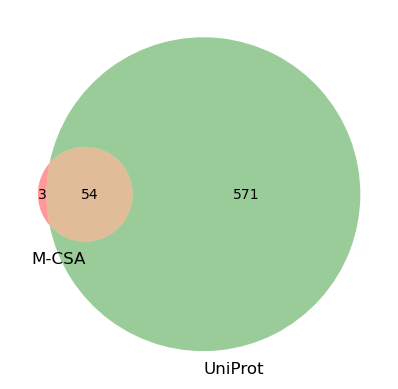

In [33]:
import matplotlib_venn

matplotlib_venn.venn2([set(df_csa_in_asd_grouped['pdb_uniprot_id']),
                       set(df_uniprot_site_annotations['uniprot_id'])],
                      ['M-CSA', 'UniProt']
                     )

In [35]:
df_uniprot_csa = df_uniprot_active_sites.merge(df_csa_in_asd_grouped, how='left', left_on='UniProt ID', right_on='pdb_uniprot_id')

active_site_residues = []

for ind, record in df_uniprot_csa.iterrows():
    if isinstance(record['catalytic_site_resids'], list):
        catalytic_site_resids = record['catalytic_site_resids']
    else:
        catalytic_site_resids = set()
    active_site_residues.append(sorted(set(record['Active Site Residues']) | catalytic_site_resids))

df_uniprot_csa['Active Site Residues'] = active_site_residues
df_uniprot_csa = df_uniprot_csa[['UniProt ID', 'Sequence', 'Active Site Residues']]
df_uniprot_csa

,UniProt ID,Sequence,Active Site Residues
0,P00720,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"[11, 20, 32, 104, 117, 132]"
1,P00519,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,"[248, 249, 250, 251, 252, 253, 254, 255, 256, ..."
2,O60239,MDAALKRSRSEEPAEILPPARDEEEEEEEGMEQGLEEEEEVDPRIQ...,[]
3,P08758,MAQVLRGTVTDFPGFDERADAETLRKAMKGLGTDEESILTLLTSRS...,[]
4,P29274,MPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVV...,"[169, 253, 277, 278]"
...,...,...,...
840,Q9HU22,MKRKGIILAGGSGTRLHPATLAISKQLLPVYDKPMIYYPLSTLMLA...,"[8, 10, 12, 13, 14, 15, 25, 26, 82, 87, 110, 1..."
841,A0A059VAZ3,MRLELPVIPLRNTVILPHTTTPVDVGRAKSKRAVEEAMGADRLIFL...,"[320, 355, 356, 357, 358, 359, 360, 361, 362, ..."
842,D0PY27,SMSYTWTGALITPCAAEESKLPINALSNSLLRHHNMVYATTSRSAG...,[]
843,Q5F4T5,MKMASNDAAPSNDGAAGLVPESNNEVMALEPVAGASLAAPVTGQTN...,[]


## Copy the allosteric site annotation to identical chains

In [38]:
df_asd_enriched.columns

Index(['Protein ASD ID', 'Gene', 'Organism', 'UniProt ID', 'PDB ID',
       'Modulator ASD ID', 'Modulator Alias', 'Modulator Chain',
       'Modulator Class', 'Allosteric Activity', 'Modulator Name',
       'Modulator Residue ID', 'ASD Function', 'Position', 'PubMed',
       'Reference Title', 'Site Overlap', 'ASD Allosteric Site Residues',
       'Map PDB Chain to UniProt', 'Oligomeric State', 'Stoichiometry',
       'Experimental Method', 'Resolution', 'Reviewed', 'Protein Name',
       '_uniprot_in_pdb'],
      dtype='object')

In [57]:
import collections
import itertools

allosteric_sites = []
for index, record in tqdm(df_asd_enriched.iterrows(), total=df_asd_enriched.shape[0]):
    protein_allosteric_sites = []

    site_residues = []
    for residue in record['ASD Allosteric Site Residues']:
        residue = residue.upper()  # Change any lower case residue names or chains to upper case
        chain = residue[0]
        # Convert chains like '1', '2', ... to 'A', 'B', ...
        if chain.isnumeric():
            chain = chr(64 + int(chain))
            residue = chain + residue[1:]  # Update the chain in the residue
        site_residues.append(residue)

    # Create a dictionary with chains with each uniprot id
    uniprot_to_chains = collections.defaultdict(list)
    chains_to_uniprot = collections.defaultdict(list)
    for chain, uniprots, seq in record['Map PDB Chain to UniProt']:
        for uniprot_id in uniprots:
            uniprot_to_chains[uniprot_id].append(chain)
            chains_to_uniprot[chain].append(uniprot_id)

    for chain, residues in itertools.groupby(site_residues, key=lambda res: res[0]):
        residue_list = list(residues)
        for uniprot in chains_to_uniprot[chain]:
            for identical_chain in uniprot_to_chains[uniprot]:
                protein_allosteric_sites.append([identical_chain, [identical_chain + res[1:] for res in residue_list]])
    allosteric_sites.append(protein_allosteric_sites)

df_asd_enriched['Allosteric Site Residues'] = allosteric_sites

100%|██████████| 3148/3148 [00:00<00:00, 30016.73it/s]


## Add active site annotation to identical chains

In [58]:
import numpy as np

uniprot_to_active_sites_map = df_uniprot_active_sites[['UniProt ID', 'Active Site Residues']]
uniprot_to_active_sites_map.set_index('UniProt ID', drop=True, inplace=True)
uniprot_to_active_sites_map = uniprot_to_active_sites_map.to_dict()['Active Site Residues']

active_sites = []
for index, record in tqdm(df_asd_enriched.iterrows(), total=df_asd_enriched.shape[0]):
    protein_active_sites = []
    for chain in record['Map PDB Chain to UniProt']:
        for uniprot_id in chain[1]:
            active_site = uniprot_to_active_sites_map[uniprot_id]
            if active_site is not np.nan:
                for residue in active_site:
                    protein_active_sites.append(f'{chain[0]}-{residue}')
    active_sites.append(protein_active_sites)

df_asd_enriched['Active Site Residues'] = active_sites

100%|██████████| 3148/3148 [00:00<00:00, 28691.40it/s]


## Add Active Site Residues from UniProt to ASD

Filter the dataframe with at least one allosteric site reidue and one active or binding site residue

In [59]:
# Drop the rows with no active site residues
df_allobench = df_asd_enriched[df_asd_enriched['Active Site Residues'].apply(len) > 0]

# Drop the rows with no allosteric site residues
df_allobench = df_allobench[df_allobench['ASD Allosteric Site Residues'].apply(len) > 0]

In [60]:
print('Number of Rows:             ', df_allobench.shape[0])
print('Number of Unique PDB IDs:   ', df_allobench['PDB ID'].nunique())
print('Number of Unique UniProt AC:', df_allobench['UniProt ID'].nunique())

Number of Rows:              2277
Number of Unique PDB IDs:    2165
Number of Unique UniProt AC: 446


In [61]:
df_allobench.to_csv(output_filename, index=False)

## Select entries with Swiss-Prot (reviewed UniProt) sequences sequence

In [ ]:
df_allobench.value_counts('Reviewed')

In [ ]:
df_allobench_reviewed = df_allobench[df_allobench['Reviewed'] == 'true'].copy()

print('Number of Rows:             ', df_allobench_reviewed.shape[0])
print('Number of Unique PDB IDs:   ', df_allobench_reviewed['PDB ID'].nunique())
print('Number of Unique UniProt AC:', df_allobench_reviewed['UniProt ID'].nunique())

In [ ]:
hist = df_allobench[['PDB ID', 'Resolution']].drop_duplicates().hist(column='Resolution', bins=range(0, 10))
for ax in hist.flatten():
    ax.set_title(None)
    ax.set_xlabel('Resolution (A)')
    ax.set_ylabel('PDB Structures')

## Select structures with resolution better than 3 Å

In [ ]:
resolution_cutoff = 3  # Select structures with a resolution better than 3 Angstroms
df_allobench_high_res = df_allobench_reviewed[df_allobench_reviewed['Resolution'] < resolution_cutoff].copy()

print('Number of Rows:             ', df_allobench_high_res.shape[0])
print('Number of Unique PDB IDs:   ', df_allobench_high_res['PDB ID'].nunique())
print('Number of Unique UniProt AC:', df_allobench_high_res['UniProt ID'].nunique())

In [ ]:
df_allobench_high_res['Modulator Class'].value_counts()

In [ ]:
df_allobench_high_res[df_allobench_high_res['Modulator Class'] == 'Lig;Ion']

In [ ]:
df_allobench_high_res

In [66]:
# df_allobench = df_allobench.drop_duplicates()
df_allobench[df_allobench.duplicated('PDB ID', keep=False)]

# Remove duplicate PDB IDs

,Protein ASD ID,Gene,Organism,UniProt ID,PDB ID,Modulator ASD ID,Modulator Alias,Modulator Chain,Modulator Class,Allosteric Activity,...,Stoichiometry,Experimental Method,Resolution,Reviewed,Protein Name,_uniprot_in_pdb,allosteric_sites,active_sites,Active Site Residues,Allosteric Site Residues
56,ASD00250000_6,,Potato,P23509,1YP4,ASD02880002,SO4,A,Ion,Activator,...,[A4],X-ray,2.30,true,Glucose-1-phosphate adenylyltransferase small ...,[P23509],"[[A-LYS-69, A-GLU-133, A-HIS-134, A-THR-135], ...","[[268], [268], [268], [268]]","[A-268, B-268, C-268, D-268]","[[A, [A-LYS-69, A-GLU-133, A-HIS-134, A-THR-13..."
57,ASD00250000_6,,Potato,P23509,1YP3,ASD02880002,SO4,A,Ion,Activator,...,[A4],X-ray,2.60,true,Glucose-1-phosphate adenylyltransferase small ...,[P23509],"[[A-LYS-69, A-GLU-133, A-HIS-134, A-THR-135], ...","[[268], [268], [268], [268]]","[A-268, B-268, C-268, D-268]","[[A, [A-LYS-69, A-GLU-133, A-HIS-134, A-THR-13..."
58,ASD00250000_6,,Potato,P23509,1YP2,ASD02880002,SO4,A,Ion,Activator,...,[A4],X-ray,2.11,true,Glucose-1-phosphate adenylyltransferase small ...,[P23509],"[[A-LYS-69, A-GLU-133, A-HIS-134, A-THR-135], ...","[[268], [268], [268], [268]]","[A-268, B-268, C-268, D-268]","[[A, [A-LYS-69, A-GLU-133, A-HIS-134, A-THR-13..."
59,ASD00250000_6,,Potato,P23509,1YP2,ASD02880002;ASD02880002,SO4;SO4,A;A,Ion,Activator,...,[A4],X-ray,2.11,true,Glucose-1-phosphate adenylyltransferase small ...,[P23509],"[[A-ARG-41, A-PRO-47, A-ARG-53, A-HIS-84, A-GL...","[[268], [268], [268], [268]]","[A-268, B-268, C-268, D-268]","[[A, [A-ARG-41, A-PRO-47, A-ARG-53, A-HIS-84, ..."
60,ASD00250000_6,,Potato,P23509,1YP4,ASD02880002;ASD02880002,SO4;SO4,A;A,Ion,Activator,...,[A4],X-ray,2.30,true,Glucose-1-phosphate adenylyltransferase small ...,[P23509],"[[A-ARG-41, A-PRO-47, A-ARG-53, A-SER-80, A-AR...","[[268], [268], [268], [268]]","[A-268, B-268, C-268, D-268]","[[A, [A-ARG-41, A-PRO-47, A-ARG-53, A-SER-80, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2843,ASD16630000_1,pyk,Mycobacterium tuberculosis (strain ATCC 25618 ...,P9WKE5,5WSB,ASD00030001,AMP,A,Lig,Activator,...,[A4],X-ray,2.25,true,Pyruvate kinase,[P9WKE5],"[[A-LYS-72, A-LYS-218, A-ASP-244, A-GLY-243, A...","[[33, 35, 36, 37, 38, 67, 74, 155, 220, 243, 2...","[A-155, A-220, A-243, A-244, A-276, A-33, A-35...","[[A, [A-LYS-72, A-LYS-218, A-ASP-244, A-GLY-24..."
2845,ASD16630000_1,pyk,Mycobacterium tuberculosis (strain ATCC 25618 ...,P9WKE5,5WSB,ASD00360002,G6P,A,Lig,Activator,...,[A4],X-ray,2.25,true,Pyruvate kinase,[P9WKE5],"[[A-PRO-453, A-PRO-452, A-ALA-397, A-MET-419, ...","[[33, 35, 36, 37, 38, 67, 74, 155, 220, 243, 2...","[A-155, A-220, A-243, A-244, A-276, A-33, A-35...","[[A, [A-PRO-453, A-PRO-452, A-ALA-397, A-MET-4..."
2874,ASD16880000_1,,Cyanophage S-TIM5,H6WFU3,4P9D,ASD02040015,TTP,A,Lig,Inhibitor,...,[A6],X-ray,2.90,false,NaN,[H6WFU3],"[[A-LYS-2], [B-LYS-2], [C-LYS-2], [D-LYS-2], [...","[[2, 22, 24, 40, 42, 43, 44, 45, 47, 48, 52, 6...","[A-95, A-104, A-117, A-2, A-22, A-40, A-42, A-...","[[A, [A-LYS-2]], [B, [B-LYS-2]], [C, [C-LYS-2]..."
2887,ASD16940000_1,,Plasmodium falciparum (isolate 3D7),Q7KQK0,5T3N,ASD16940001,75G,A,Lig,Inhibitor,...,[A1],X-ray,2.40,false,NaN,[Q7KQK0],"[[A-GLU-377, A-ILE-366, A-ILE-340, A-ALA-359, ...","[[258, 259, 260, 261, 268, 269, 317, 319, 376,...","[A-258, A-259, A-260, A-261, A-268, A-269, A-3...","[[A, [A-GLU-377, A-ILE-366, A-ILE-340, A-ALA-3..."
